# Tensorflow Core Algorithms
- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow.feature_column as fc
import tensorflow as tf
import tensorflow_probability as tfp

## Linear Regression
Linear corresponance between datapoints

In [2]:
# Load datasets

X_train = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")  # train data
X_test = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")  # test data

In [3]:
X_train.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
X_test.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [5]:
y_train = X_train.pop("survived")
y_test = X_test.pop("survived")

In [6]:
X_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


<AxesSubplot:>

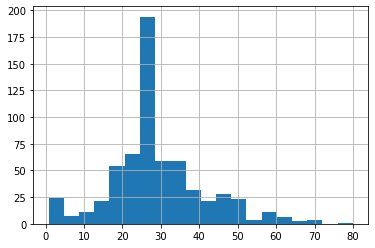

In [7]:
X_train.age.hist(bins=20)

<AxesSubplot:>

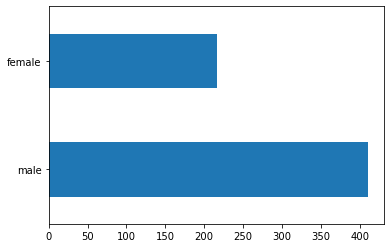

In [8]:
X_train["sex"].value_counts().plot(kind="barh")

<AxesSubplot:>

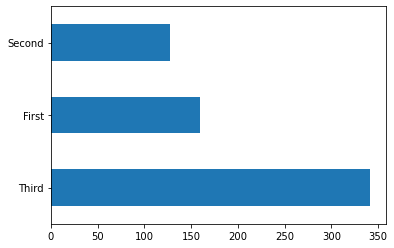

In [9]:
X_train["class"].value_counts().plot(kind="barh")

Text(0.5, 0, ' % survival chance')

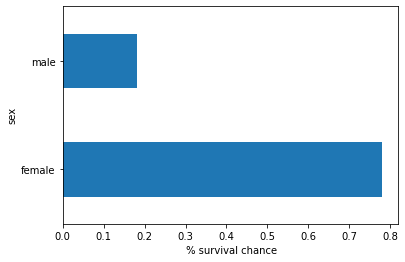

In [10]:
pd.concat([X_train, y_train], axis=1).groupby('sex')["survived"].mean()\
    .plot(kind="barh").set_xlabel(" % survival chance")

In [11]:
X_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [12]:
categorical_columns = ["sex", "class", "deck", "parch", "embark_town", "alone", "n_siblings_spouses"]
numeric_columns = ["age", "fare"]

feature_columns = []
for feature_name in categorical_columns:
    vocabulary = X_train[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


display(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int6

## Input Function
Convert data into batches so model can learn 

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

In [14]:
train_input_fn = make_input_fn(X_train, y_train)
test_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43yyd_9u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [16]:
linear_est.train(train_input_fn)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp43yyd_9u/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 555.018
INFO:tensorflow:loss = 0.25845838, step = 100 (0.181 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tm

In [17]:
result = linear_est.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-01-09T11:54:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp43yyd_9u/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.29929s
INFO:tensorflow:Finished evaluation at 2023-01-09-11:54:16
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.7613636, accuracy_baseline = 0.625, auc = 0.83501685, auc_precision_recall = 0.7862024, average_loss = 0.47102904, global_step = 200, label/mean = 0.375, loss = 0.46227556, precision = 0.6875, prediction/mean = 0.36704352, recall = 0.6666667
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmp43yyd_9u/model.ckpt-200


In [18]:
display(result)

{'accuracy': 0.7613636,
 'accuracy_baseline': 0.625,
 'auc': 0.83501685,
 'auc_precision_recall': 0.7862024,
 'average_loss': 0.47102904,
 'label/mean': 0.375,
 'loss': 0.46227556,
 'precision': 0.6875,
 'prediction/mean': 0.36704352,
 'recall': 0.6666667,
 'global_step': 200}

In [19]:
result = list(linear_est.predict(test_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp43yyd_9u/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
display(result[0]['probabilities'])
display(result[0]['probabilities'][1])  # Not Survived - idx 0, Survived - idx 1

array([0.9353111 , 0.06468894], dtype=float32)

0.064688936

In [21]:
y_test.loc[3]

1

In [22]:
display(result[3]['probabilities'])

array([0.44463304, 0.5553669 ], dtype=float32)

# Classification

## Dataset
This specific dataset seperates flowers into 3 different classes of species.
- Setosa
- Versicolor
- Virginica

The information about each flower is the following.
- sepal length
- sepal width
- petal length
- petal width

In [23]:
column_names = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth", "Species"]
species = ["Setosa", "Versicolor", "Virginica"]

In [24]:
train_path = tf.keras.utils.get_file("iris_training.csv",  "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file("iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

X_train = pd.read_csv(train_path, names=column_names, header=0)
y_train = pd.read_csv(test_path, names=column_names, header=0)

In [25]:
train_df.head()

NameError: name 'train_df' is not defined

In [26]:
X_test = X_train.pop("Species")
y_test = y_train.pop("Species")

In [27]:
X_train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


## Input Function

In [28]:
def input_fn(features, labels, training=True, batch_size=256):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle and repeat if training
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

## Feature Columns

In [29]:
feature_columns = []
for key in X_train.keys():
    feature_columns.append(tf.feature_column.numeric_column(key=key))

## Building Model

- DNNClassifier (Deep Neural Network)
- LinearClassifier

In [30]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively
    hidden_units=[30, 10],
    # Choose between 3 classes
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp34hbx3n6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training

In [31]:
classifier.train(
    input_fn=lambda: input_fn(X_train, X_test, training=True), steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp34hbx3n6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.4519801, step = 0
INFO:tensorflow:global_step/sec: 1215.11
INFO:tensorflow:loss = 0.92183, step = 100 (0.083 sec)
INFO:tensorflow:global_step/sec: 1760.57
INFO:tensorflow:loss = 0.8080174, step = 200 (0.057 sec)
INFO:tensorflow:global_step/sec: 1846.9
INFO:tensorflow:loss = 0.7445857, step = 300 (0.054 sec)
INFO:tensorflow:global_step/sec: 1837.13
INFO:tensorflow:loss = 0.6898552, step = 400 (0.054 sec)
INFO:tensorflow:global_step/sec: 1796.65
INFO:tensorflow:loss = 0.6641305, step = 500 (0.056 sec)
INFO:tens

In [32]:
classifier_result = classifier.evaluate(input_fn=lambda: input_fn(y_train, y_test, training=False))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-01-09T11:54:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp34hbx3n6/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.11373s
INFO:tensorflow:Finished evaluation at 2023-01-09-11:54:48
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.96666664, average_loss = 0.31240734, global_step = 5000, loss = 0.31240734
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp34hbx3n6/model.ckpt-5000


In [33]:
features = column_names[:-1]
predict = {}

In [34]:
features

['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']

In [35]:
print("Enter numeric values only \t :")
for feature in features:
    val = input(feature + ":")
    if not val.isdigit(): 
        break
    predict[feature] = [float(val)]

Enter numeric values only 	 :


SepalLength: 34
SepalWidth: 23
PetalLength: 2
PetalWidth: 4


In [36]:
predict

{'SepalLength': [34.0],
 'SepalWidth': [23.0],
 'PetalLength': [2.0],
 'PetalWidth': [4.0]}

In [37]:
def input_fn_predict(features, batch_size=256):
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)
    

In [38]:
predictions = classifier.predict(input_fn=lambda: input_fn_predict(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]
    print(f"Prediction is {species[class_id]} with {probability*100} probability")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp34hbx3n6/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is Setosa with 100.0 probability


## Clustering
#### Basic Algorithm for K-Means.
- Step 1: Randomly pick K points to place K centroids
- Step 2: Assign all the data points to the centroids by distance. The closest centroid to a point is the one it is assigned to.
- Step 3: Average all the points belonging to each centroid to find the middle of those clusters (center of mass). Place the corresponding centroids into that position.
- Step 4: Reassign every point once again to the closest centroid.
- Step 5: Repeat steps 3-4 until no point changes which centroid it belongs to.

## Hidden Markov Models
"The Hidden Markov Model is a finite set of states, each of which is associated with a (generally multidimensional) probability distribution <br> Transitions among the states are governed by a set of probabilities called transition probabilities." <br> 
A hidden markov model works with probabilities to predict future events or states.<br>

**States:** In each markov model we have a finite set of states. These states could be something like "warm" and "cold" or "high" and "low" or even "red", "green" and "blue". These states are "hidden" within the model, which means we do not direcly observe them.

**Observations:** Each state has a particular outcome or observation associated with it based on a probability distribution. An example of this is the following: *On a hot day Tim has a 80% chance of being happy and a 20% chance of being sad.*

**Transitions:** Each state will have a probability defining the likelyhood of transitioning to a different state. An example is the following: *a cold day has a 30% chance of being followed by a hot day and a 70% chance of being follwed by another cold day.*

To create a hidden markov model we need.
- States
- Observation Distribution
- Transition Distribution

### Weather Model
Taken direclty from the TensorFlow documentation (https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel). 

We will model a simple weather system and try to predict the temperature on each day given the following information.
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being cold.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is
 normally distributed with mean and standard deviation 0 and 5 on
 a cold day and mean and standard deviation 15 and 10 on a hot day.

If you're unfamiliar with **standard deviation** it can be put simply as the range of expected values. 

In this example, on a hot day the average temperature is 15 and ranges from 5 to 25.

To model this in TensorFlow we will do the following.

In [39]:
tfd = tfp.distributions
initial_distribution = tfd.Categorical(probs=[0.8, 0.2]) # point 2
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]]) # point 3, 4
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.]) # point 5

# loc represents mean - scale is standard deviation

In [40]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [41]:
mean = model.mean()
mean.numpy()

array([3.       , 5.9999995, 7.4999995, 8.25     , 8.625001 , 8.812501 ,
       8.90625  ], dtype=float32)

## Sources

1. Chen, James. “Line Of Best Fit.” Investopedia, Investopedia, 29 Jan. 2020, www.investopedia.com/terms/l/line-of-best-fit.asp.
2. “Tf.feature_column.categorical_column_with_vocabulary_list.” TensorFlow, www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list?version=stable.
3. “Build a Linear Model with Estimators &nbsp;: &nbsp; TensorFlow Core.” TensorFlow, www.tensorflow.org/tutorials/estimator/linear.
4. Staff, EasyBib. “The Free Automatic Bibliography Composer.” EasyBib, Chegg, 1 Jan. 2020, www.easybib.com/project/style/mla8?id=1582473656_5e52a1b8c84d52.80301186.
5. Seif, George. “The 5 Clustering Algorithms Data Scientists Need to Know.” Medium, Towards Data Science, 14 Sept. 2019, https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68.
6. Definition of Hidden Markov Model, http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html.
7. “Tfp.distributions.HiddenMarkovModel &nbsp;: &nbsp; TensorFlow Probability.” TensorFlow, www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel.